# Standardizing Geographic Units Over Time

A common issue in spatial analysis is that geographic tabulation units can (and often do) change over time. For instance the U.S. census boundary polygons like tracts and blocks are re-drawn with each census to accomodate population growth and change. That means it's impossible to see if tract XZY has changed over time because "tract XYZ" means something different in each time period. To help solve that problem geosnap leverages the pysal [`tobler`](https://pysal.org/tobler) package to harmonize spatial boundaries over time. Doing so is as simple as calling the `Community.harmonize()` method

## Original Data

First, we'll create a new Community from San Diego county

In [1]:
from geosnap import Community

Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 2841.03entries/s]


Using the `from_census` constructor, we'll grab some original census data which by default, includes data from 1990, 2000, and 2010 and adjusts all currency columns for inflation by converting them into 2015 dollars (if you want to suppress this behavior set `constant_dollars=False`). Here's how median contract has changed in San Diego county if we plot maps of the original boundaries

In [2]:
sd = Community.from_census(county_fips="06073")

There are several different harmonization techniques in the literature (for a deeper dive on spatial interpolation checkout the `tobler` library) but nearly all of them require good estimates of source and target polygon areas. That means it's important to set a reasonable CRS for the study region (which should be a familiar habit anyway). In this case, [epsg 6246](https://epsg.io/6246) is appropriate

In [3]:
sd.gdf = sd.gdf.to_crs(6426)

SubplotsContainer([CartesianAxesSubplot(0.0279167,0.273999;0.310387x0.664281), CartesianAxesSubplot(0.354651,0.273979;0.310387x0.664319), CartesianAxesSubplot(0.681542,0.274021;0.310387x0.664235)])

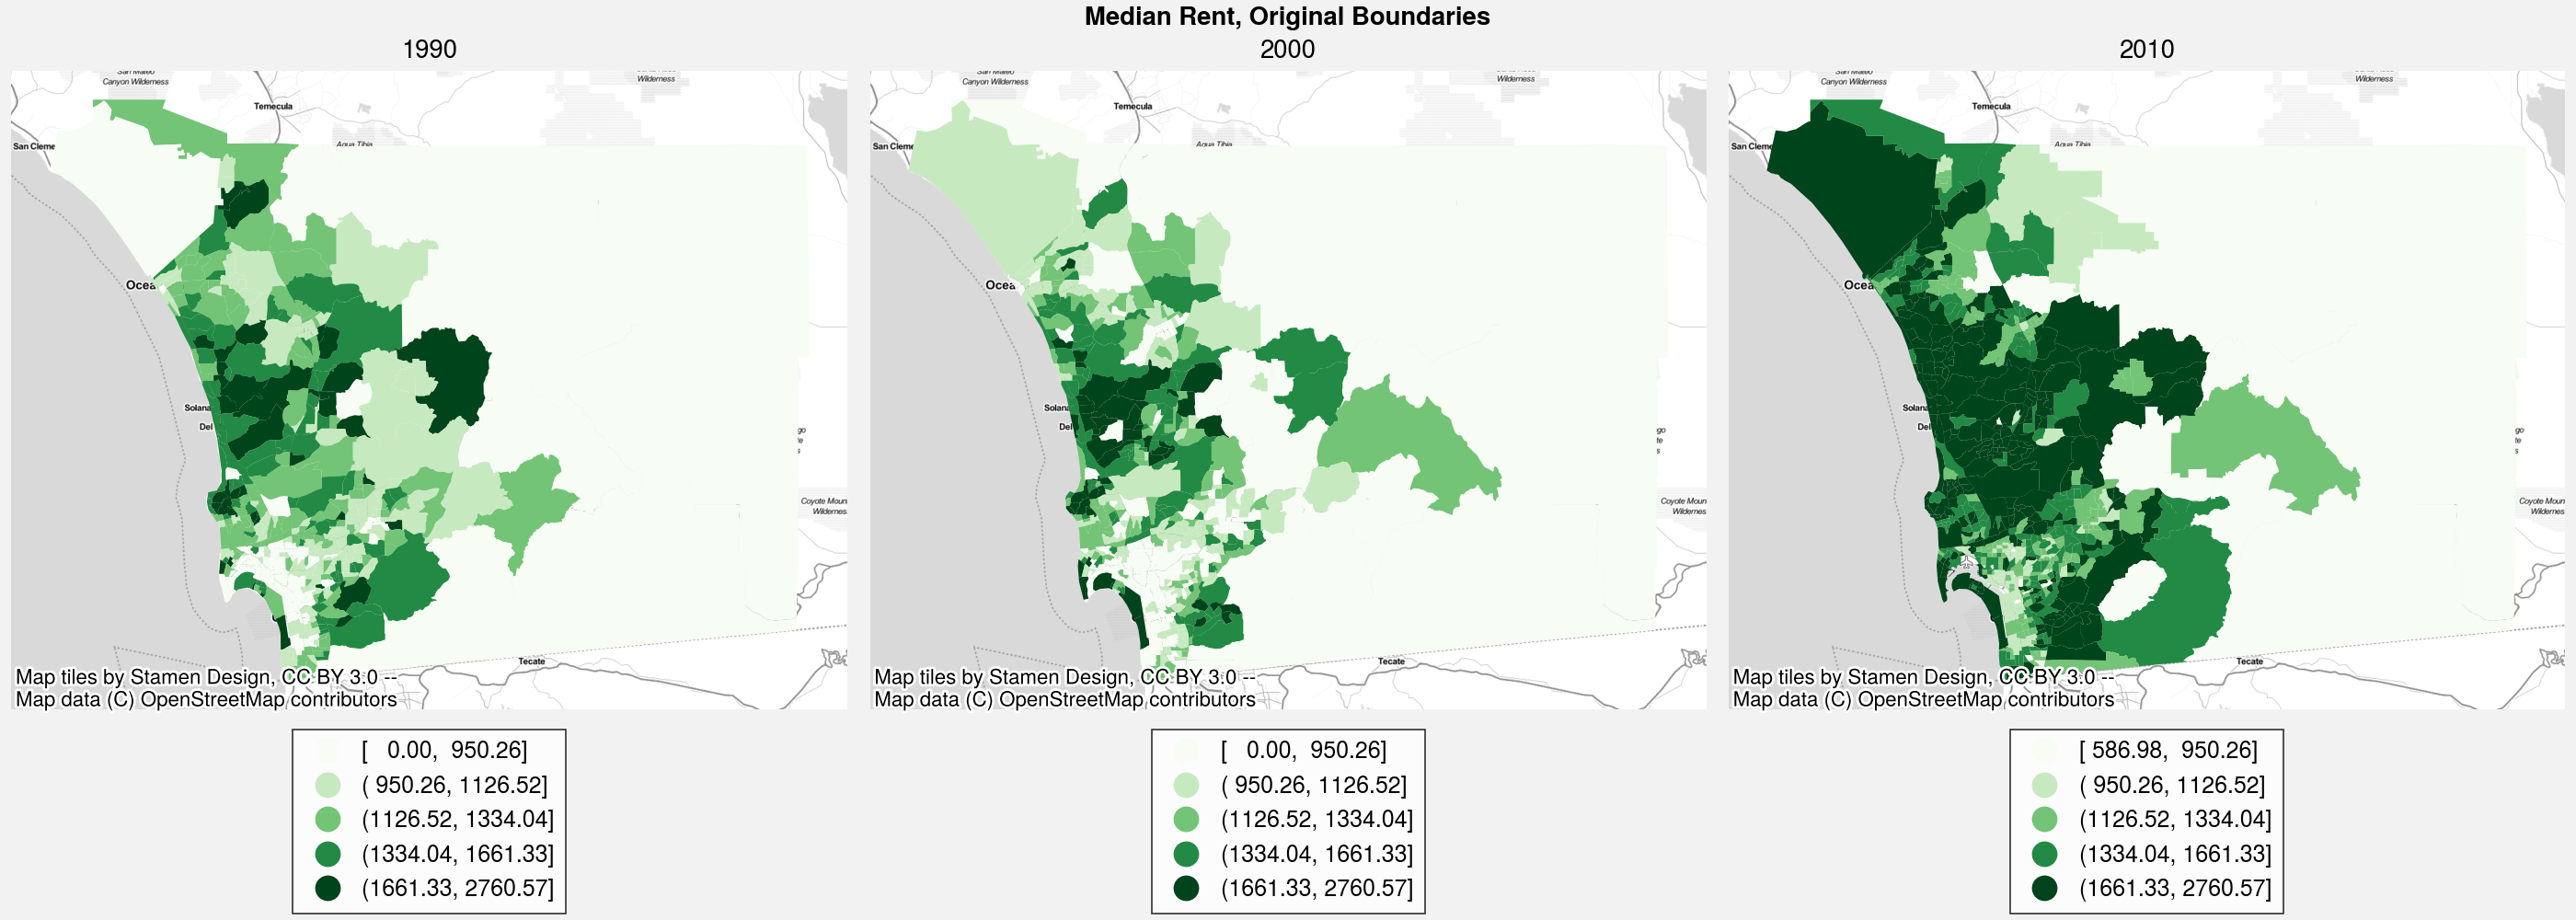

In [4]:
sd.plot_timeseries(
    "median_contract_rent", title="Median Rent, Original Boundaries",
    cmap='Greens',
    dpi=200,
    figsize=(14,5)
)

It looks like San Diego county has gotten dramatically more expensive over time, particularly through the 2000s. But since the underlying geographic units are changing over time, we still can't make tract-to-tract comparisons, so we can harmonize the boundaries. Here we'll take each census year and convert population and median income data into constant 2010 boundaries. 

## Harmonization using Areal Interpolation

The simplest way to harmonize boundaries is to use areal interpolation, meaning we use the area of overlap between consecutive years to create a weighted sum of intersecting polygons. This approach assumes each polygon has constant density of each attribute so its most useful when the polygons are small and homogenous

When harmonizing boundaries over time, we need to distinguish between [intensive and extensive](https://en.wikipedia.org/wiki/Intensive_and_extensive_properties) variables because each needs to be handled differently during the interpolation process. Median income is a statistic (so intensive), whereas total population is a count (extensive), so we make sure to pass each to the appropriate list

In [5]:
sd_harm10 = sd.harmonize(
    intensive_variables=["median_contract_rent", 'p_hispanic_persons'],
    extensive_variables=["n_total_pop"],
    weights_method="area",
    target_year=2010,
)

Harmonizing 1990
Harmonizing 2000



SubplotsContainer([CartesianAxesSubplot(0.0279167,0.274092;0.310331x0.664094), CartesianAxesSubplot(0.354755,0.274092;0.310331x0.664094), CartesianAxesSubplot(0.681594,0.274092;0.310331x0.664094)])

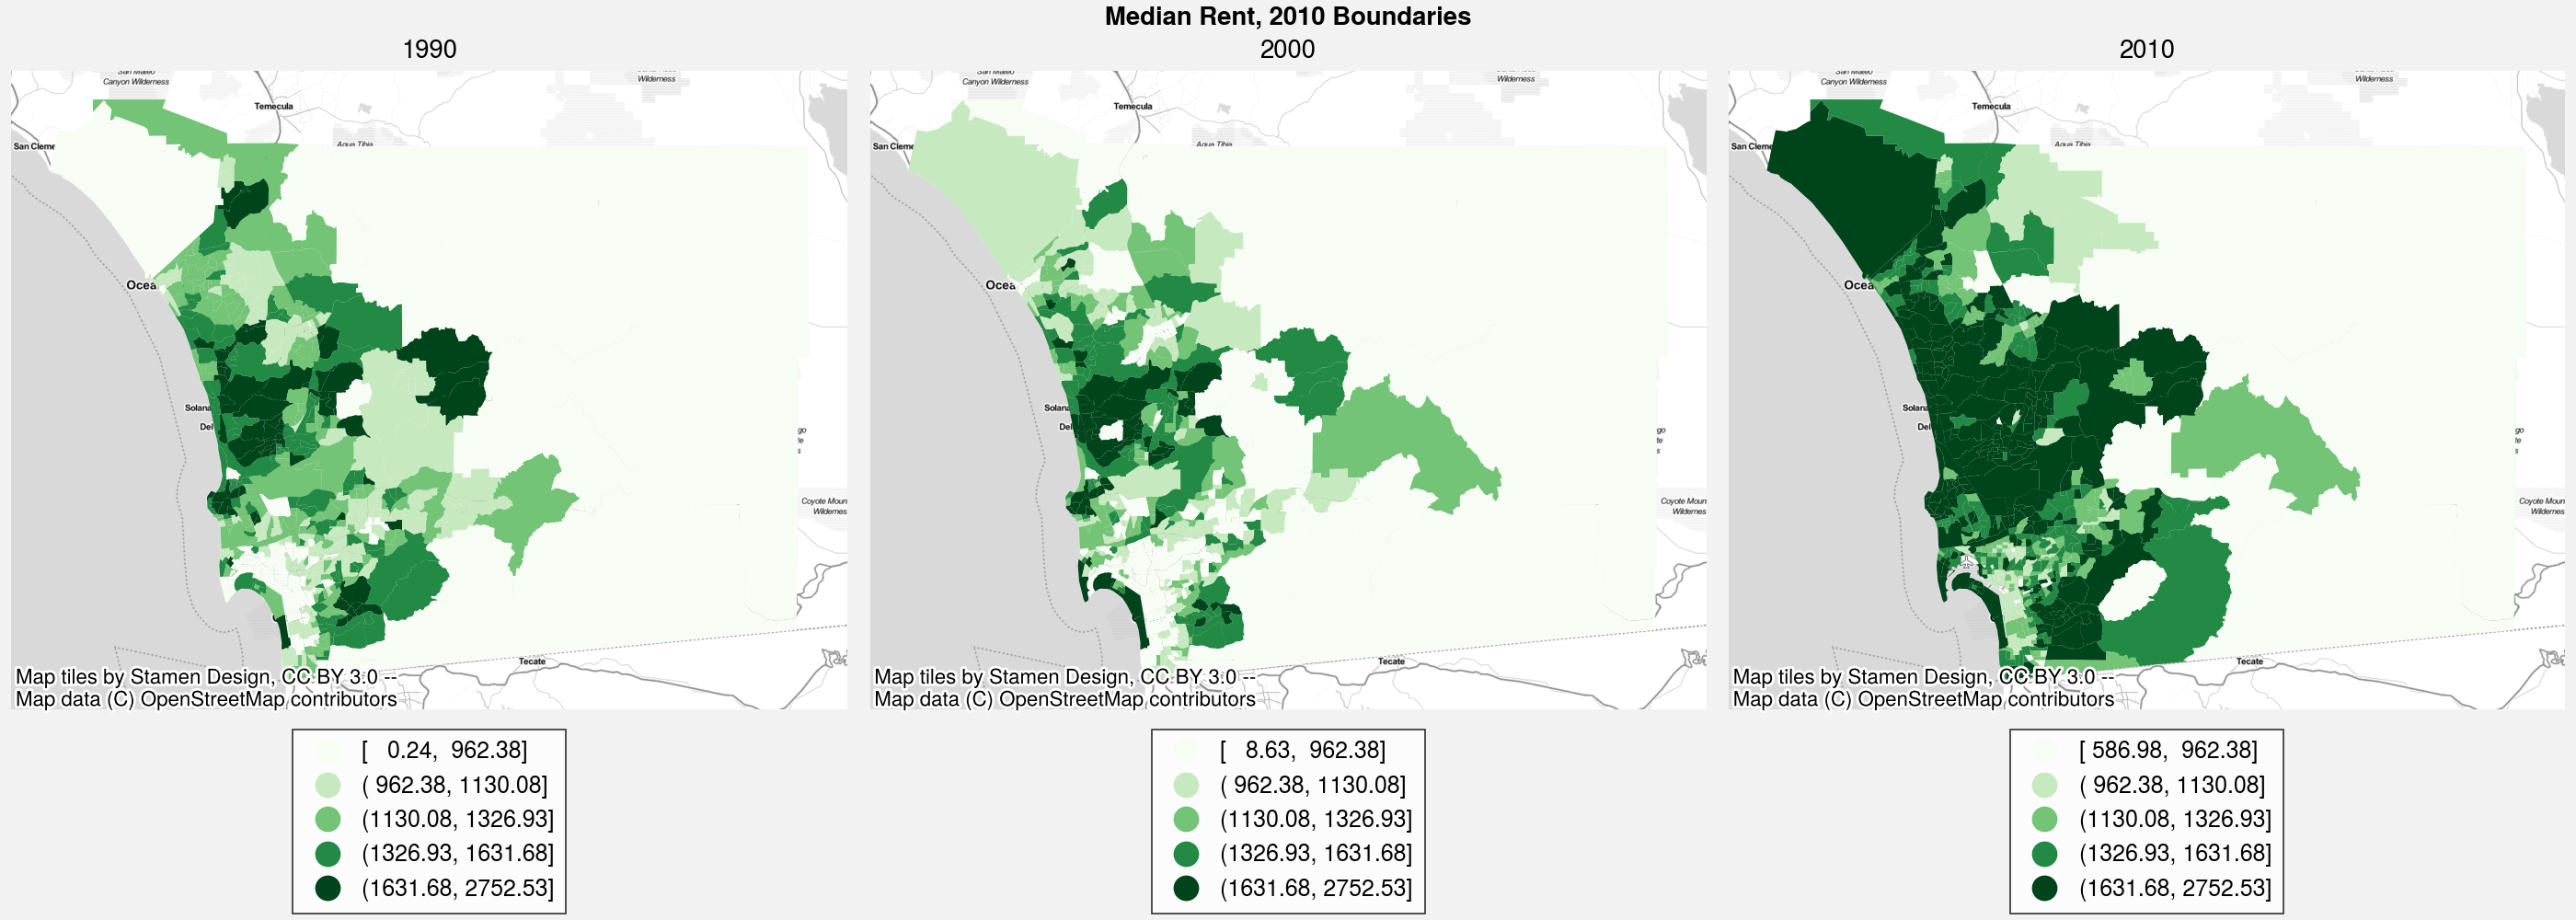

In [6]:
sd_harm10.plot_timeseries(
    "median_contract_rent", title="Median Rent, 2010 Boundaries",
    cmap='Greens',
    dpi=200,
    figsize=(14,5)
)

SubplotsContainer([CartesianAxesSubplot(0.0279167,0.274092;0.310331x0.664094), CartesianAxesSubplot(0.354755,0.274092;0.310331x0.664094), CartesianAxesSubplot(0.681594,0.274092;0.310331x0.664094)])

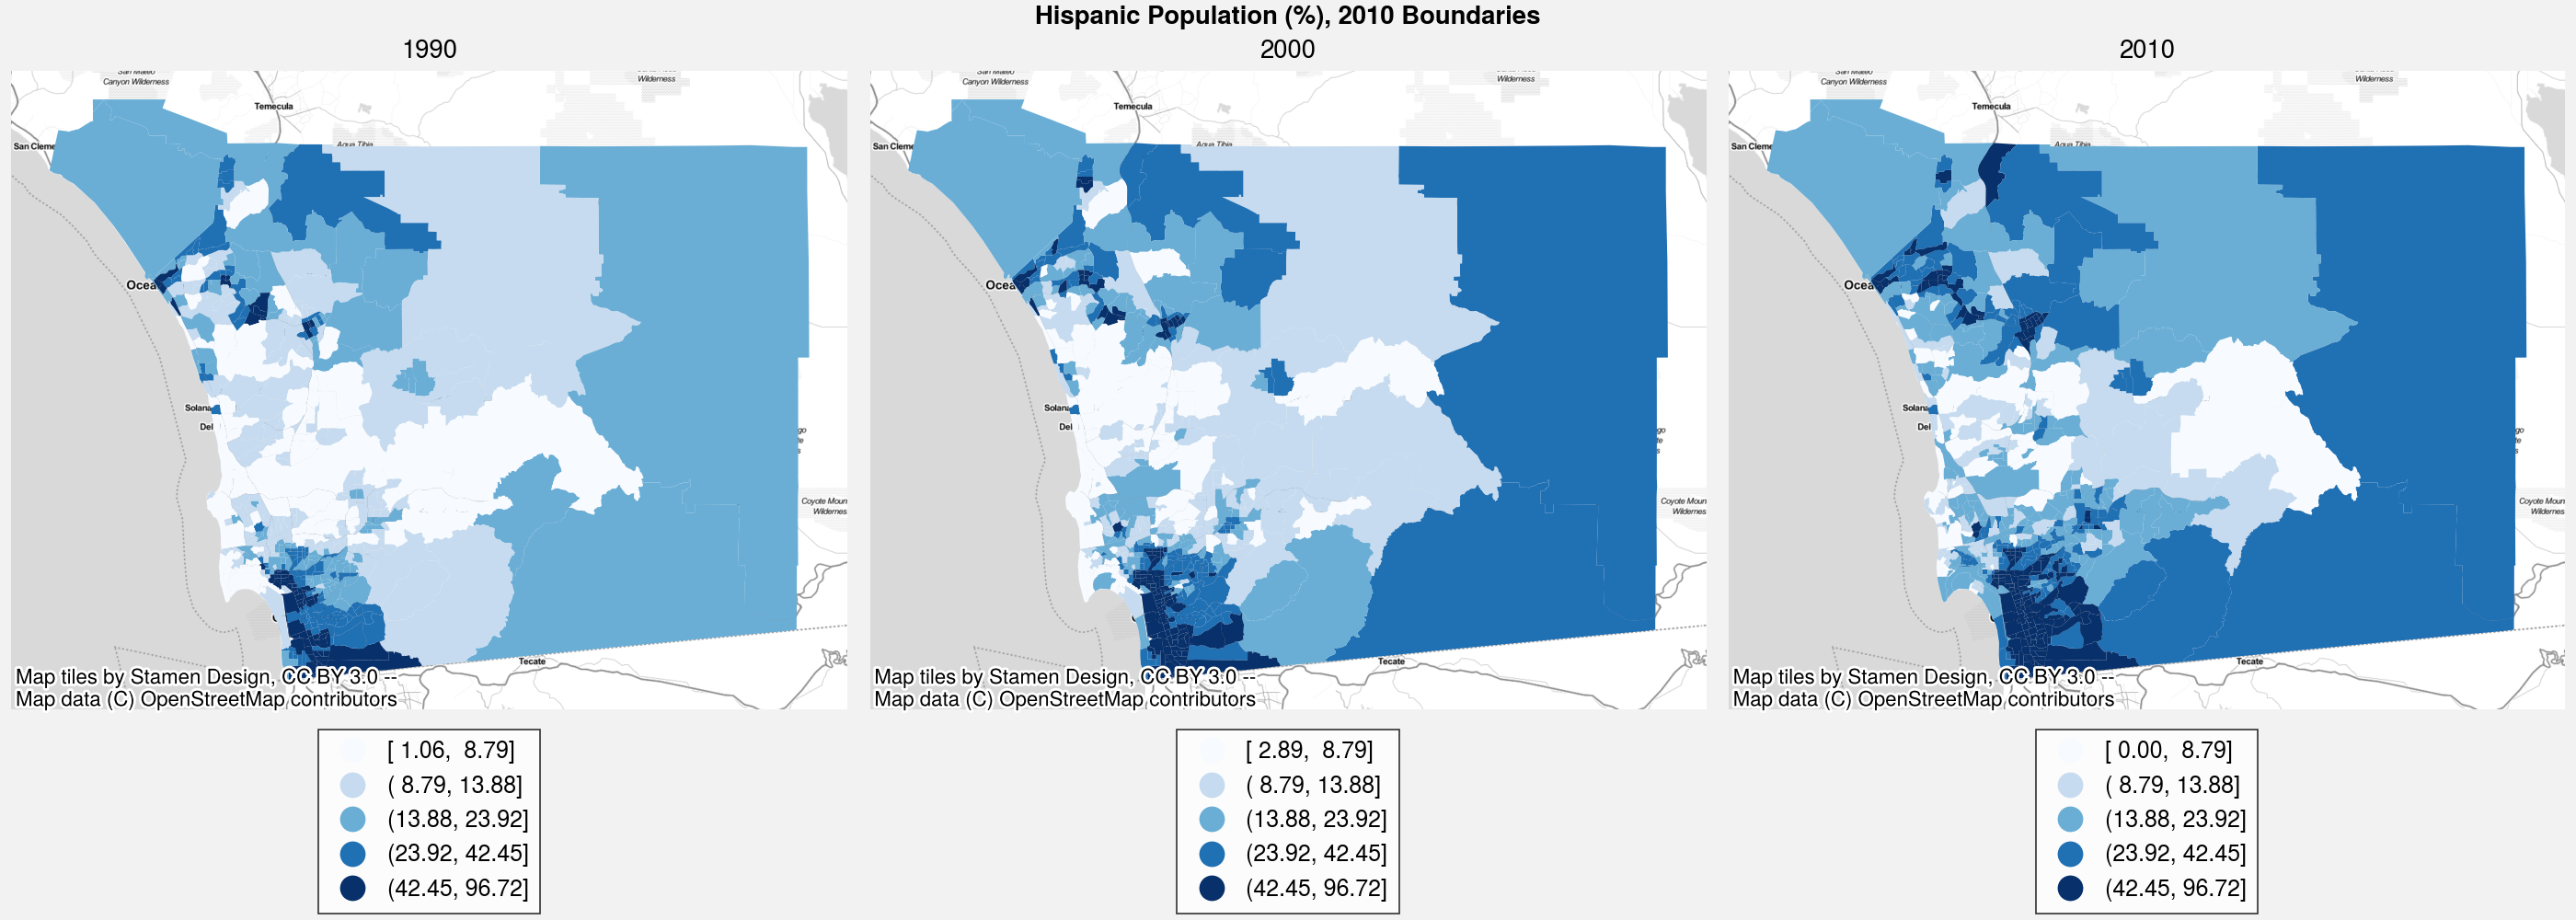

In [7]:
sd_harm10.plot_timeseries(
    "p_hispanic_persons", title="Hispanic Population (%), 2010 Boundaries",
    dpi=200,
    figsize=(14,5)
)

We could also use 1990 boundaries as our target to see how the region has evolved according to those units:

Harmonizing 2000
Harmonizing 2010


/Users/knaaptime/Dropbox/projects/tobler/tobler/util/util.py:28: UserWarning: nan values in variable: median_contract_rent, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


SubplotsContainer([CartesianAxesSubplot(0.0279167,0.27388;0.310497x0.664517), CartesianAxesSubplot(0.354755,0.27388;0.310497x0.664517), CartesianAxesSubplot(0.681594,0.27388;0.310497x0.664517)])

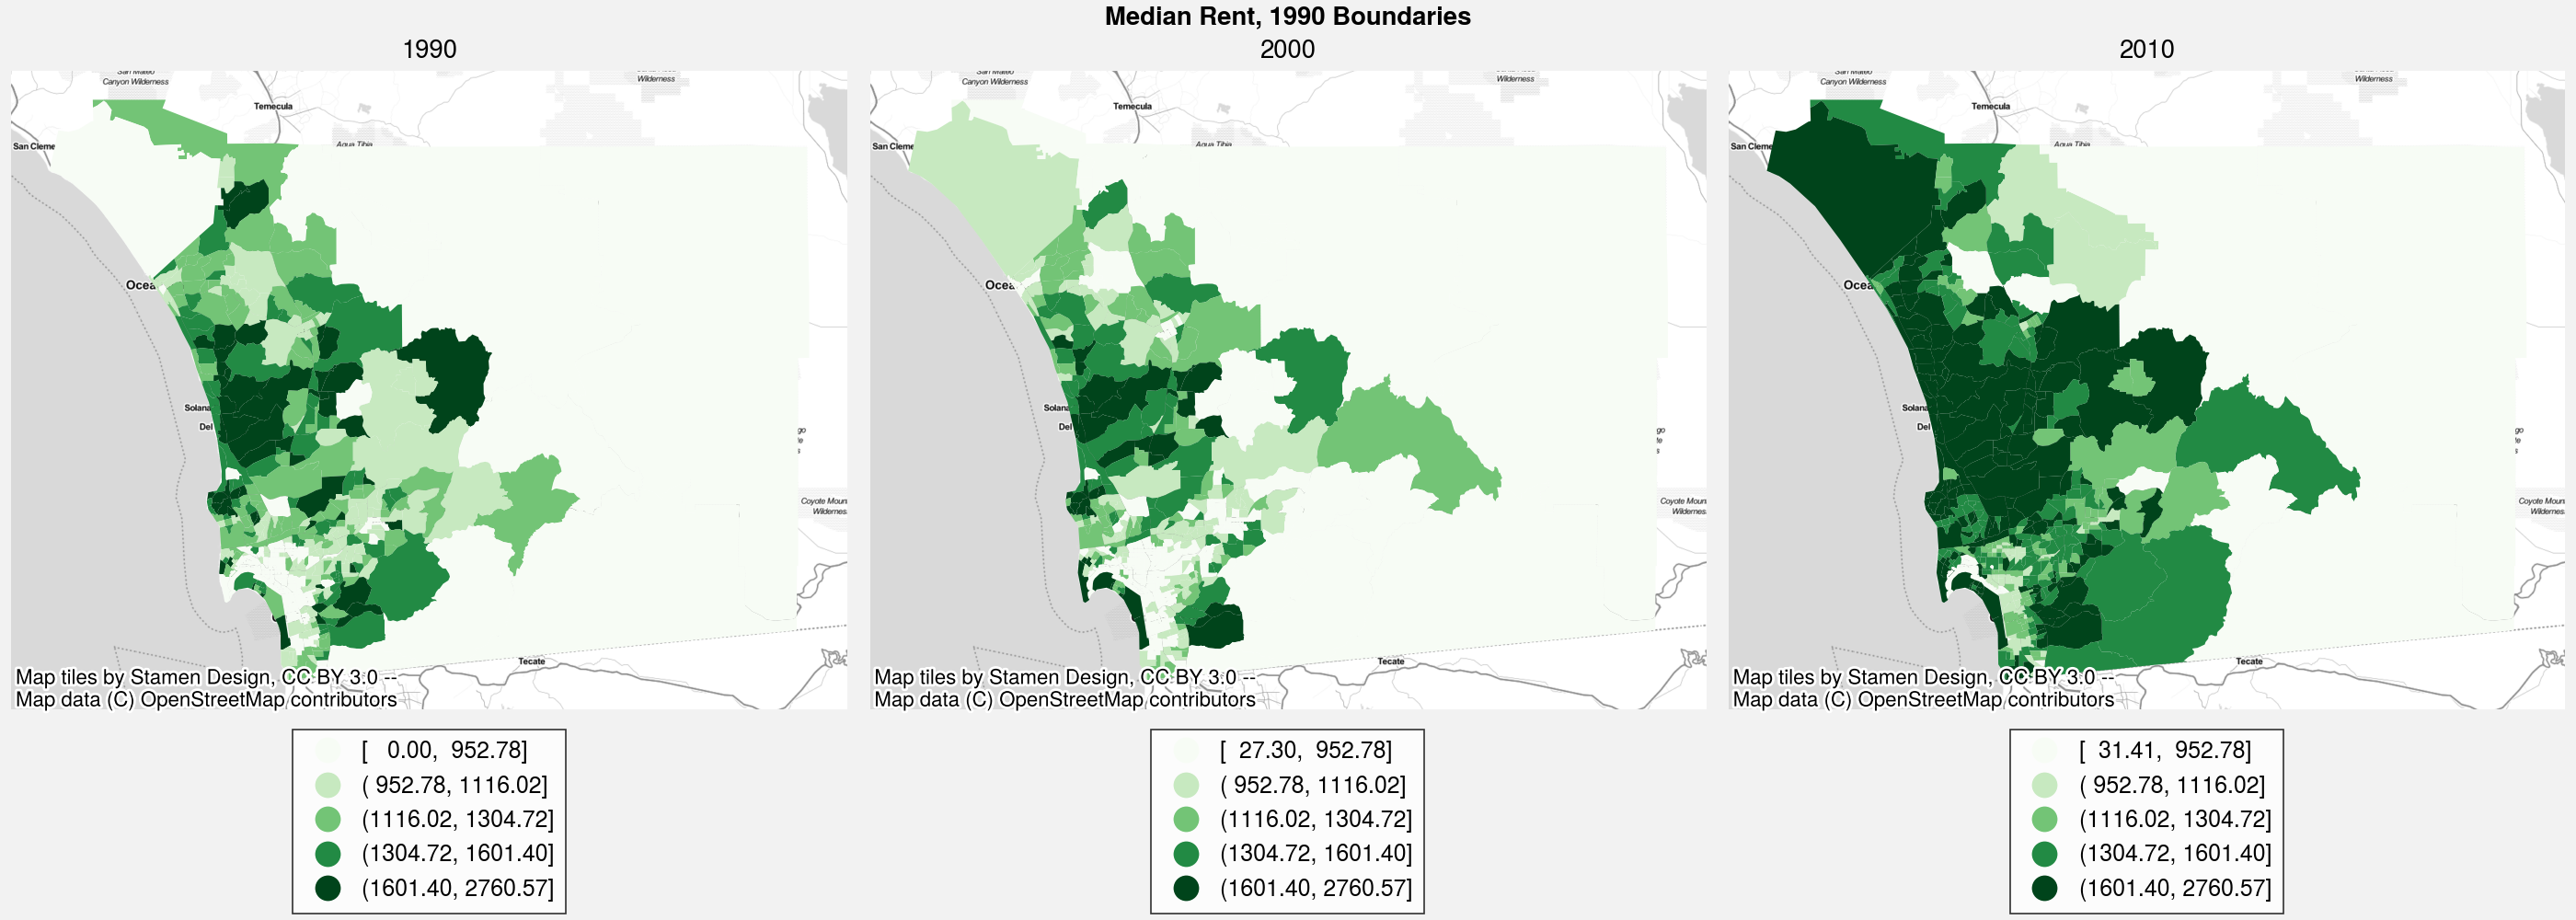

In [8]:
sd_harm90 = sd.harmonize(
    intensive_variables=["median_contract_rent"],
    weights_method="area",
    target_year=1990,
)

sd_harm90.plot_timeseries(
    "median_contract_rent", 
    title="Median Rent, 1990 Boundaries",
    cmap='Greens',
    dpi=200,
    figsize=(14,5)
)

## Harmonization using Dasymetric Interpolation

To account for the fact that most variables are not distributed uniformly thoughout the polygon (e.g. development is often clustered rather than spread evenly throughout each census tract), geosnap can use [dasymetric interpolation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6420221/) that incorporates additional information for a more accurate harmonization. In this case, we can use raster data like [the NLCD](https://www.mrlc.gov/) to constrain our interpolation to only the developed part of each census tract.

[spatialucr](https://spatial.ucr.edu) distributes an optimized version of the NLCD data through its [quilt bucket](https://open.quiltdata.com/b/spatial-ucr) for use in harmonization so we can download it simply using quilt. Since we're harmonizing boundaries from the past, our auxiliary data should roughly match the time period of the polygon data we're converting. The earliest version of the NLCD available is 2001, so we'll use that

(note the next cell will download a 1.5gb tif file into the working directory)

In [ ]:
import quilt3

quilt3.Package.browse("rasters/nlcd", "s3://spatial-ucr")["nlcd_2001.tif"].fetch(dest="./")

To use dasymetric harmonization, we need to change the `weights_method` and provide a path to a valid raster file (which, in this case, we just downloaded to th current dir). When using a raster file as a dasymetric mask, we need to tell the function which raster cells are part of the mask. In this case, the pixels in the NLCD raster to different land use types, and we want to constrain the interpolation to developed land. So here we'll set the `codes` argument to the developed land types from the nlcd: 
- 21 (Developed, Open Space)
- 22 (Developed, Low Intensity)
- 23 (Developed, Medium Intensity) 
- 24 (Developed, High Intensity)

(which are also the defaults)

Note: dasymetric interpolation is much more data intensive so it takes considerably longer to calculate. On my machine it takes roughly 4 minutes per time period for this study area, whereas the pure areal interpolation completes in a few seconds each

In [9]:
sd_harm10_dasy = sd.harmonize(
    intensive_variables=["median_contract_rent"],
    weights_method="dasymetric",
    raster='nlcd_2001.tif',
    codes=[21, 22, 23, 24],
    target_year=2010,
)

Harmonizing 1990


/Users/knaaptime/Dropbox/projects/tobler/tobler/area_weighted/area_interpolate.py:494: UserWarning: The CRS for the generated union will be set to be the same as source_df.
  "The CRS for the generated union will be set to be the same as source_df."
/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Harmonizing 2000


/Users/knaaptime/Dropbox/projects/tobler/tobler/area_weighted/area_interpolate.py:494: UserWarning: The CRS for the generated union will be set to be the same as source_df.
  "The CRS for the generated union will be set to be the same as source_df."
/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


SubplotsContainer([CartesianAxesSubplot(0.0279167,0.274092;0.310331x0.664094), CartesianAxesSubplot(0.354755,0.274092;0.310331x0.664094), CartesianAxesSubplot(0.681594,0.274092;0.310331x0.664094)])

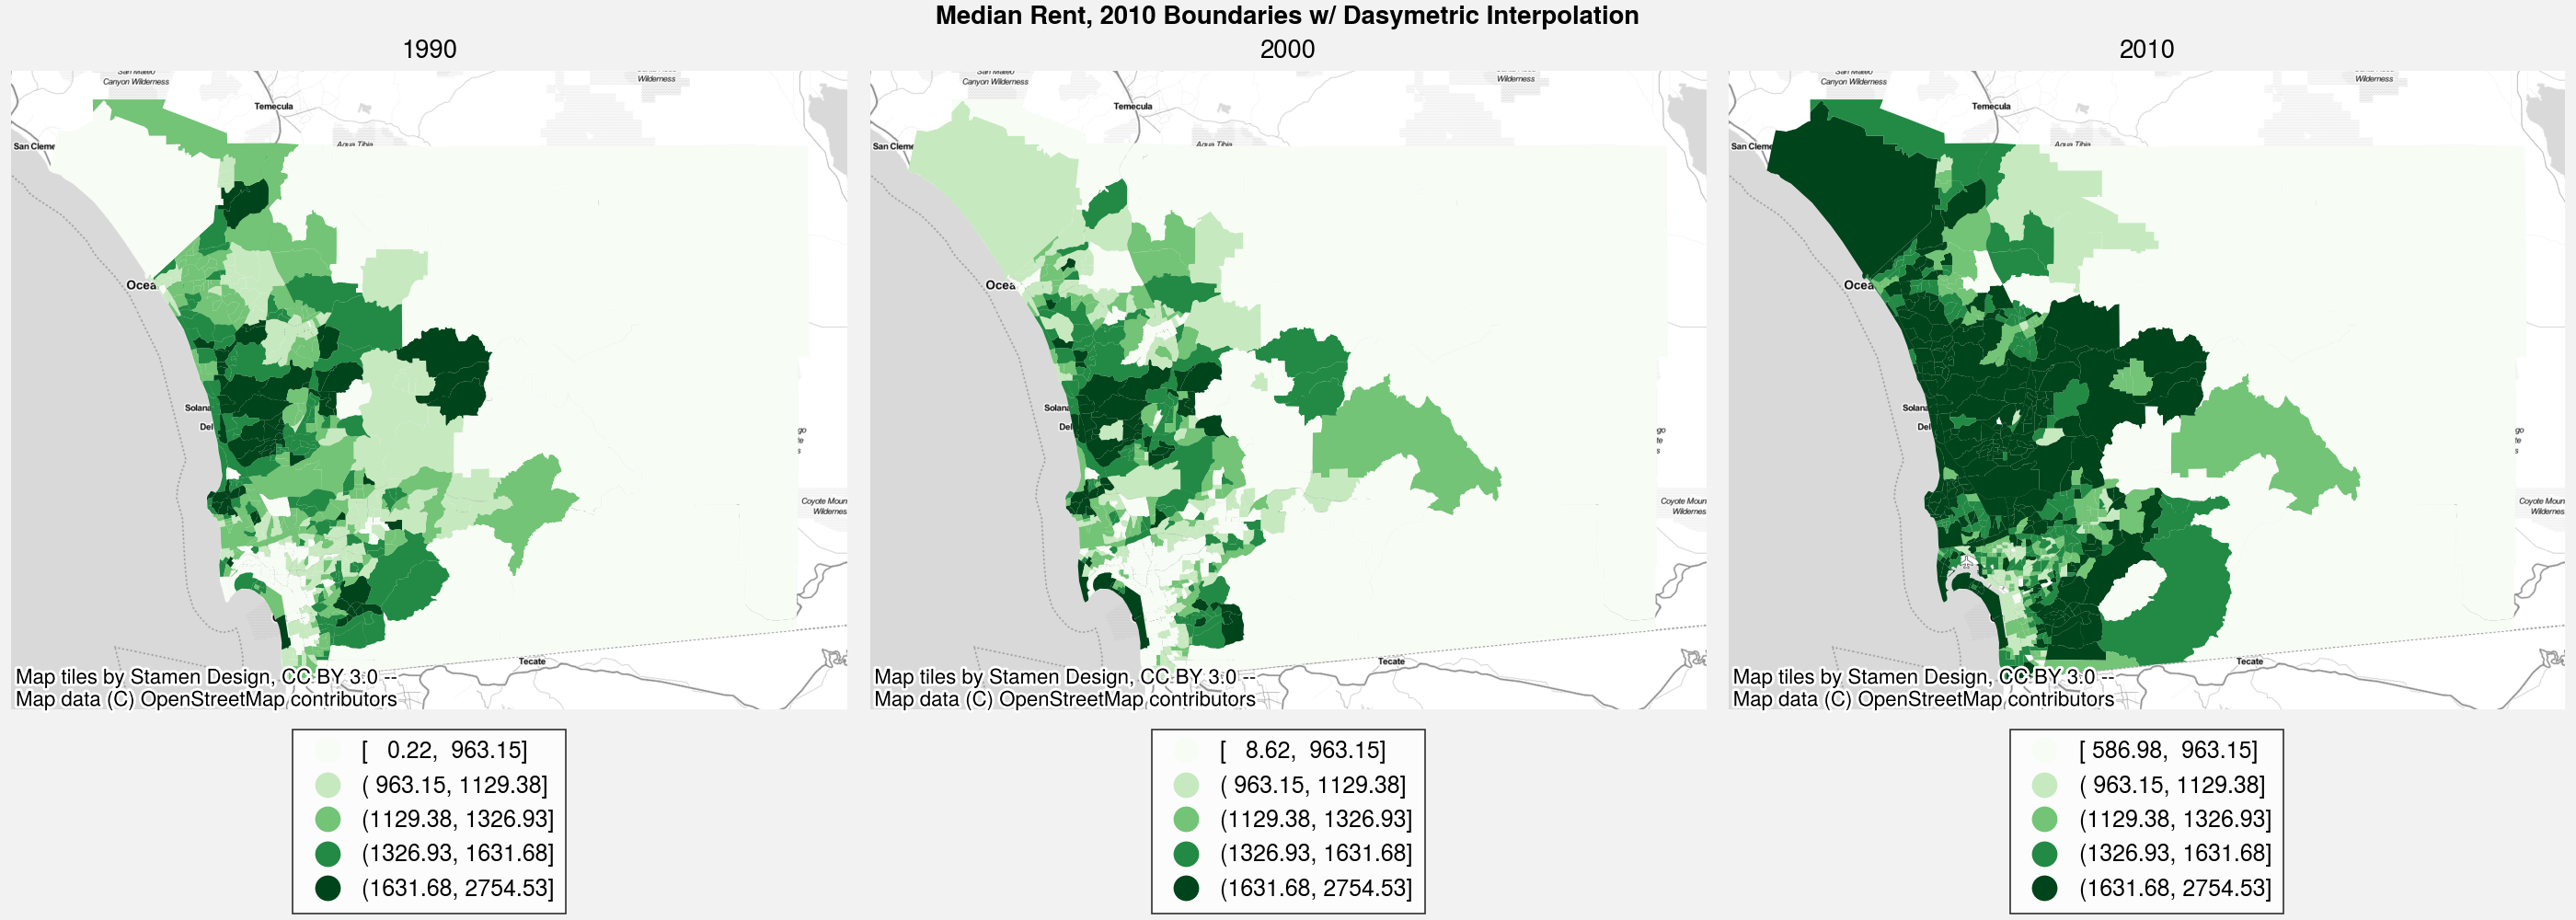

In [10]:
sd_harm10_dasy.plot_timeseries(
    "median_contract_rent", title="Median Rent, 2010 Boundaries w/ Dasymetric Interpolation",
    dpi=200,
    cmap='Greens',
    figsize=(14,5)
)

The NLCD is a useful dasymetric layer because it has high spatial resolution and classifies a relatively wide range of land uses. By constraining our interpolation to developed land uses we ensure that there are no variables allocated to obviously incorrect places like forests, lakes, or farms. But it doesnt do anything to prevent allocating variables to  developed land uses that don't have population--like heavy industry, airports, parking lots, or shopping malls. Depending on the particular problem and location, you may want to inclue or exclude different pixel types. There may also be better raster sources that could be used as alternatives